#References
[Kaggle](https://www.kaggle.com/code/deepthyrosejose/exploratory-data-analysis-of-fmri-neuroimaging/notebook)

[datascience](https://towardsdatascience.com/using-neural-networks-for-a-functional-connectivity-classification-of-fmri-data-ff0999057bc6)

[Github](https://github.com/harsharaman/bold5000_fmri)

[Code example](https://github.com/gelanat/network_neuroscience/blob/master/functional%20connectivity%20using%20neural%20nets.ipynb)

#Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Install module

In [ ]:
# !pip install nilearn

#Import lib

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nilearn import image, plotting

import warnings
warnings.simplefilter('ignore')

%matplotlib inline

In [ ]:
#Fixing seed for reproducibility
np.random.seed(0) 

In [ ]:
from nilearn import datasets
num = 40
adhd_data = datasets.fetch_adhd(n_subjects=num)

In [ ]:
adhd_data.keys()

dict_keys(['func', 'confounds', 'phenotypic', 'description'])

In [ ]:
len(adhd_data['func'])

40

In [ ]:
#Getting the functional files
func = adhd_data.func
print(func[0])

/root/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz


In [ ]:
#Using nilearn's individual component analysis for group level
from nilearn import decomposition

canica = decomposition.CanICA(n_components=20, mask_strategy='background')
canica.fit(func)

CanICA(mask_strategy='background')

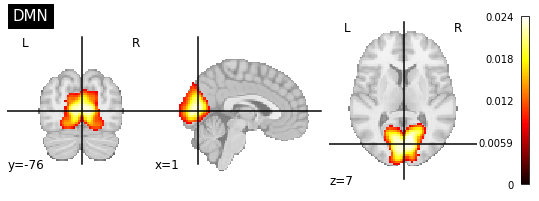

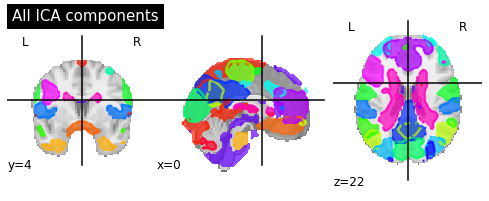

In [ ]:
#Retrieving the components
components = canica.components_

#Using a masker to project into the 3D space
components_img = canica.masker_.inverse_transform(components)

#Plotting the default mode network (DMN) without region extraction
plotting.plot_stat_map(image.index_img(components_img, 9), title='DMN')
plotting.show()

#Plotting all the components
plotting.plot_prob_atlas(components_img, title='All ICA components')
plotting.show()

In [ ]:
#Using a filter to extract the regions time series 
from nilearn import input_data
masker = input_data.NiftiMapsMasker(components_img, smoothing_fwhm=6,
                         standardize=False, detrend=True,
                         t_r=2.5, low_pass=0.1,
                         high_pass=0.01)



#Computing the regions signals and extracting the phenotypic information of interest
subjects = []
adhds = []
sites = []
labels = []
for func_file, confound_file, phenotypic in zip(
        adhd_data.func, adhd_data.confounds, adhd_data.phenotypic):
    time_series = masker.fit_transform(func_file, confounds=confound_file)
    subjects.append(time_series)
    is_adhd = phenotypic['adhd']
    if is_adhd == 1:
        adhds.append(time_series)    
    sites.append(phenotypic['site'])
    labels.append(phenotypic['adhd'])

In [ ]:
#Comparing the three types of functional connectivity between the regions of interest
from nilearn.connectome import ConnectivityMeasure

connectivity_biomarkers = {}

kinds = ['correlation', 'partial correlation', 'tangent']
for kind in kinds:
    conn_measure = ConnectivityMeasure(kind=kind, vectorize=True)
    connectivity_biomarkers[kind] = conn_measure.fit_transform(subjects)

# For each kind, all individual coefficients are stacked in a unique 2D matrix.
print('{0} correlation biomarkers for each subject.'.format(
    connectivity_biomarkers['tangent'].shape[1]))

210 correlation biomarkers for each subject.


In [ ]:
#Stratifying the data to use for comparison

from sklearn.model_selection import StratifiedKFold

classes = ['{0}{1}'.format(site_name, adhd_label)
           for site_name, adhd_label in zip(sites, labels)]
cv = StratifiedKFold(n_splits=3)

In [ ]:
#Classifying using the connectivity coefficients and linear support vector
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

mean_scores = []
for kind in kinds:
    svc = LinearSVC(random_state=0)
    cv_scores = cross_val_score(svc,
                                connectivity_biomarkers[kind],
                                y=labels,
                                cv=cv,
                                groups=labels,
                                scoring='accuracy',
                                )
    mean_scores.append(cv_scores.mean())

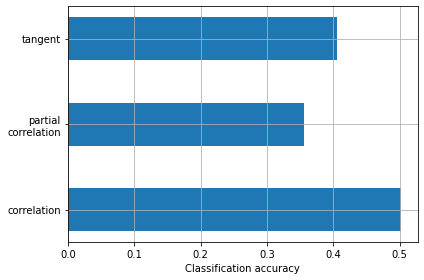

In [ ]:
#Visualizing results and accuracy
from nilearn.plotting import show

plt.figure(figsize=(6, 4))
positions = np.arange(len(kinds)) * .1 + .1
plt.barh(positions, mean_scores, align='center', height=.05)
yticks = [kind.replace(' ', '\n') for kind in kinds]
plt.yticks(positions, yticks)
plt.xlabel('Classification accuracy')
plt.grid(True)
plt.tight_layout()

show()

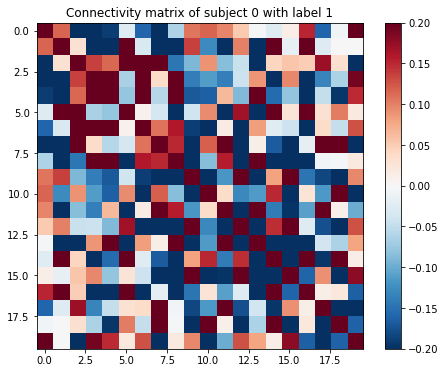

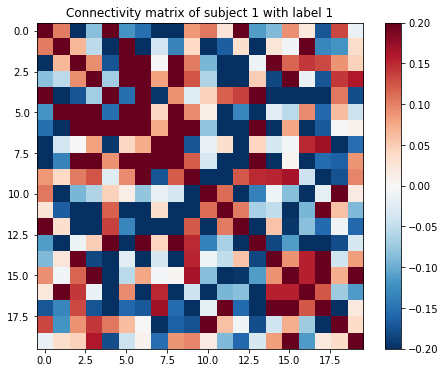

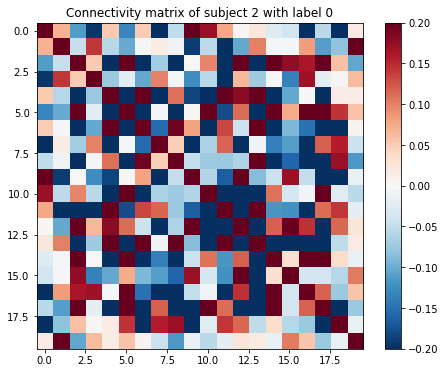

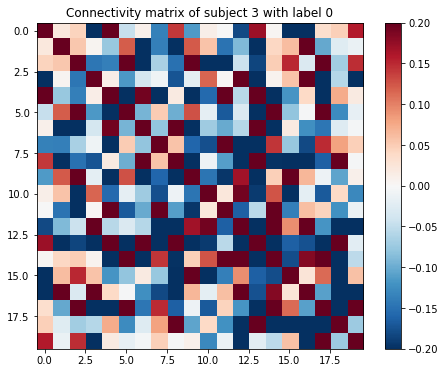

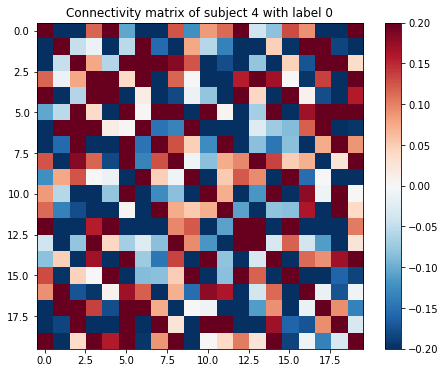

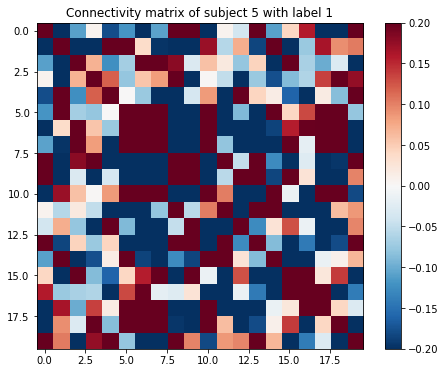

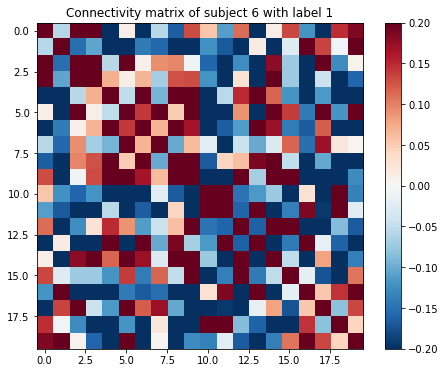

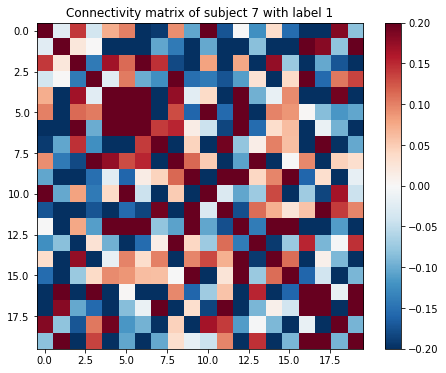

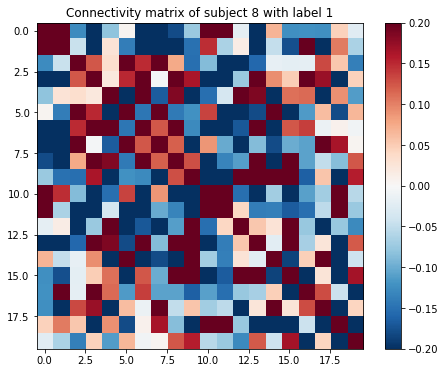

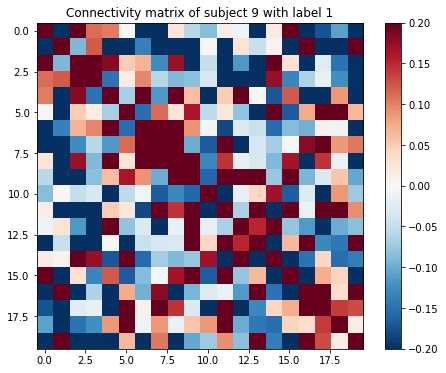

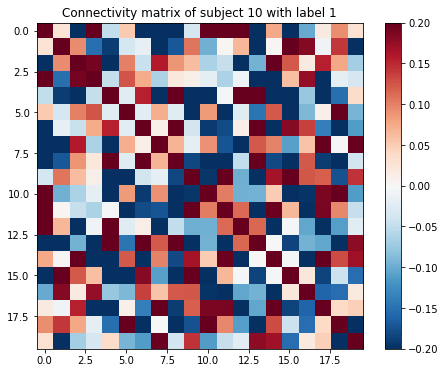

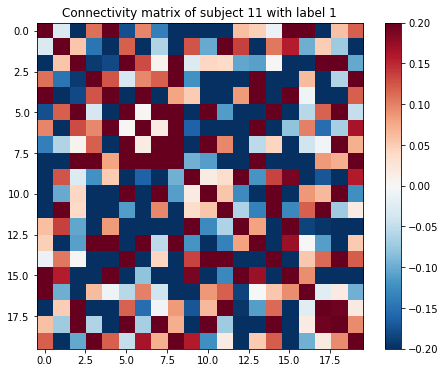

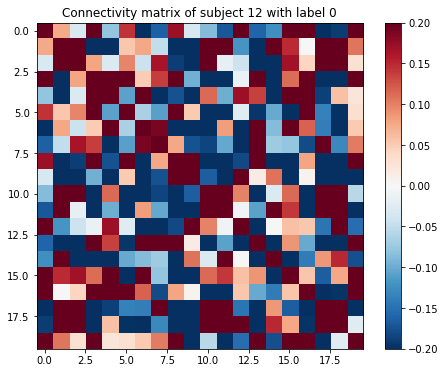

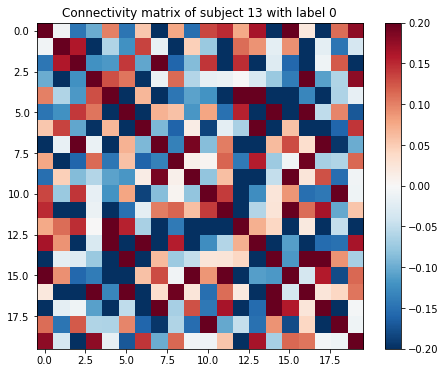

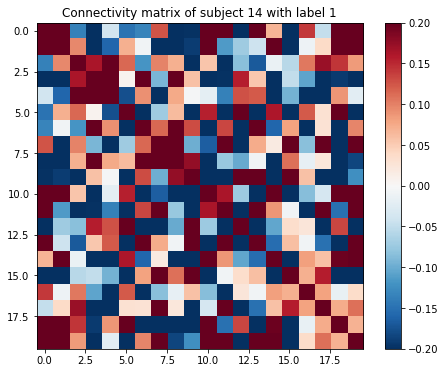

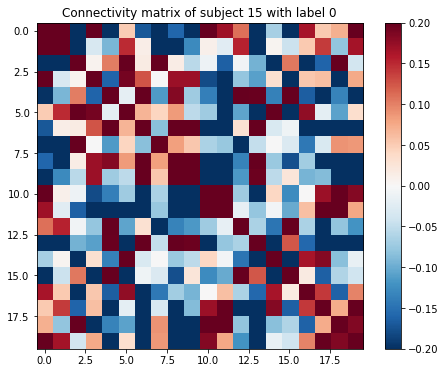

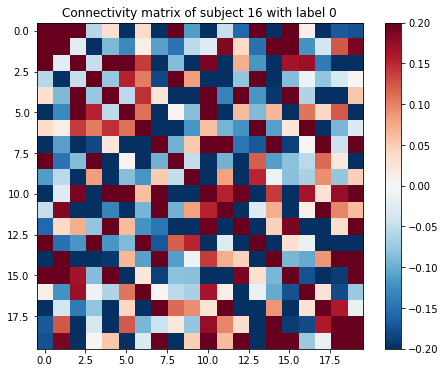

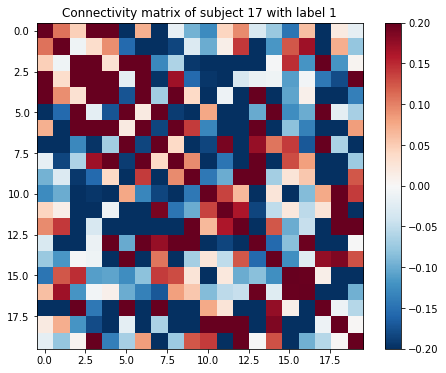

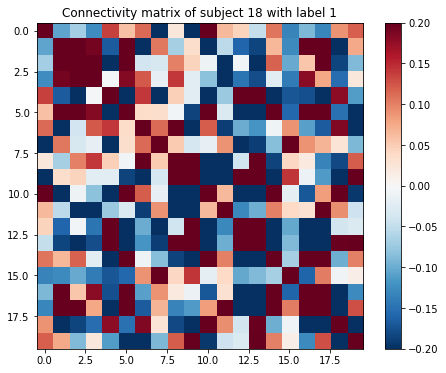

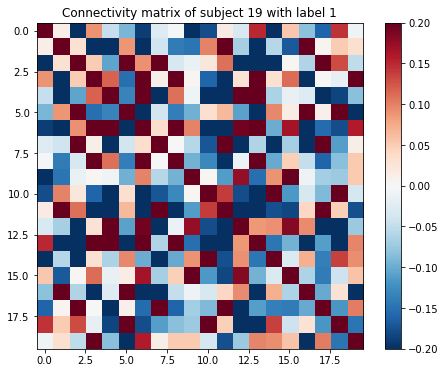

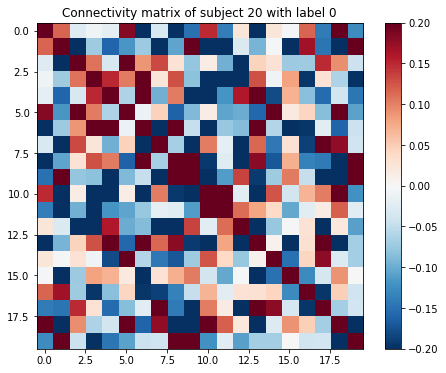

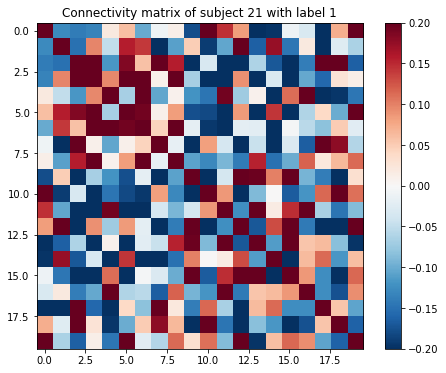

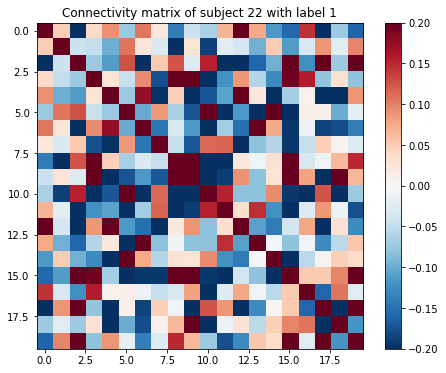

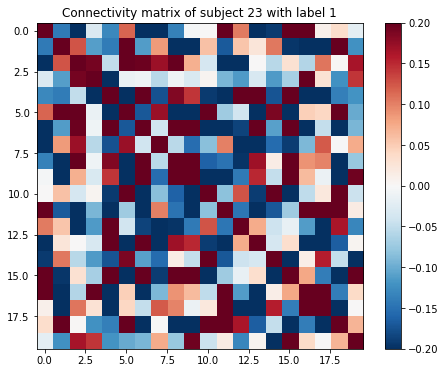

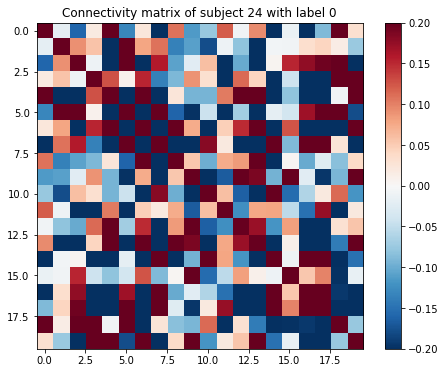

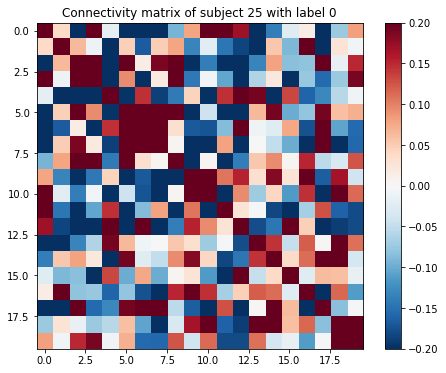

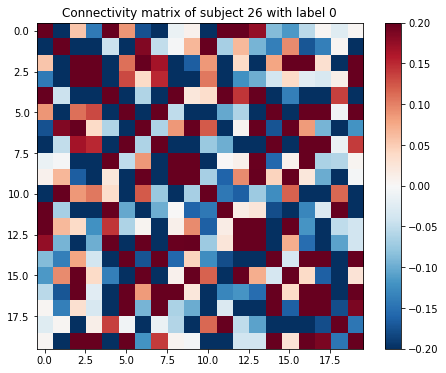

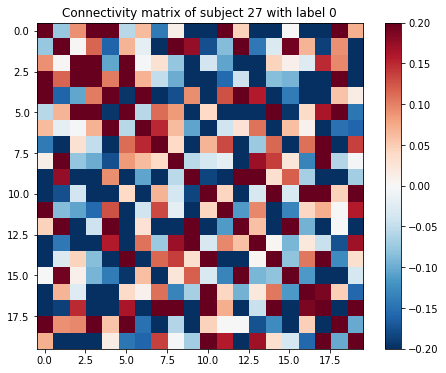

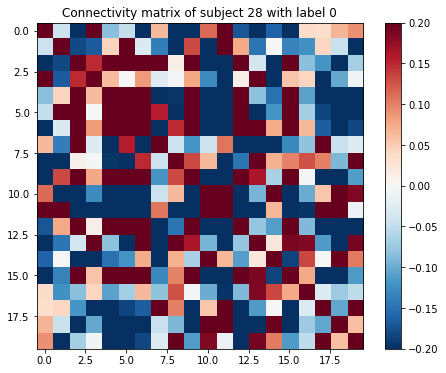

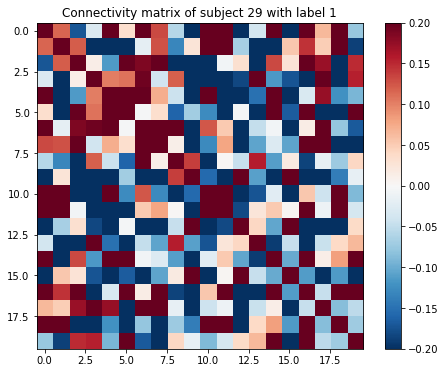

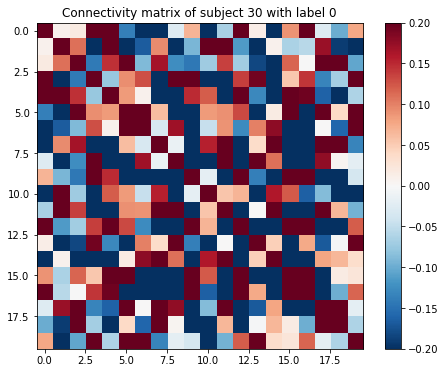

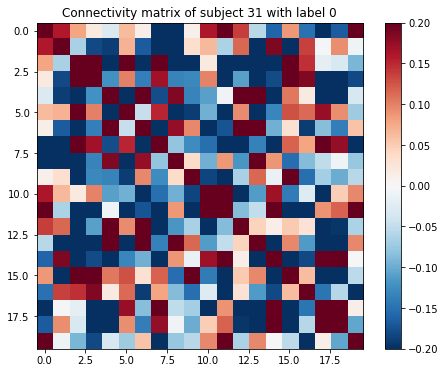

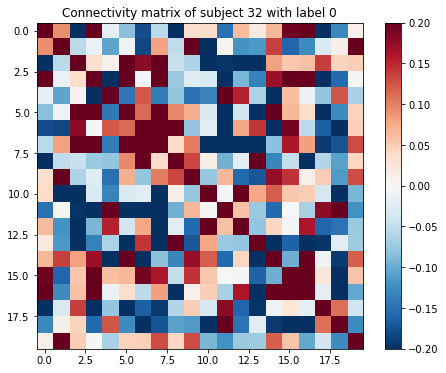

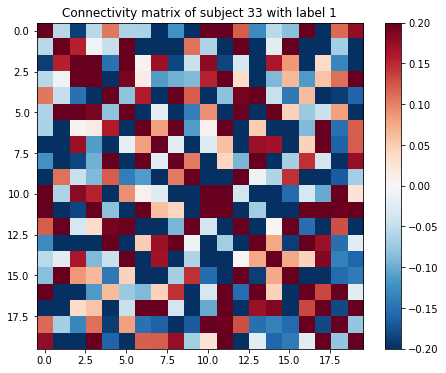

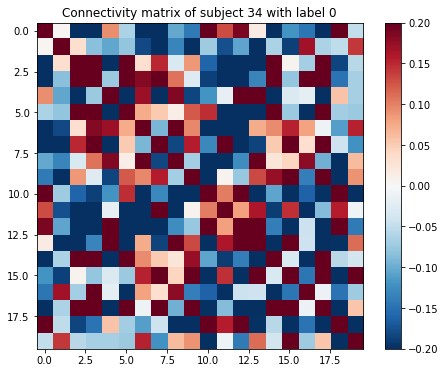

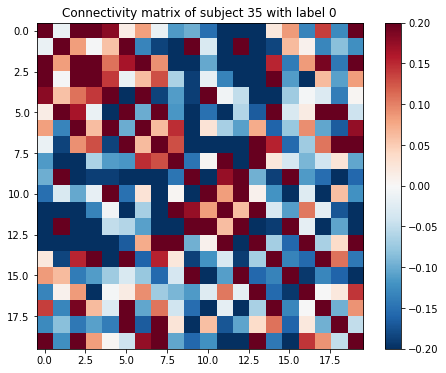

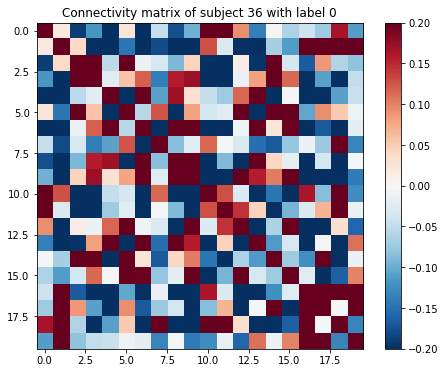

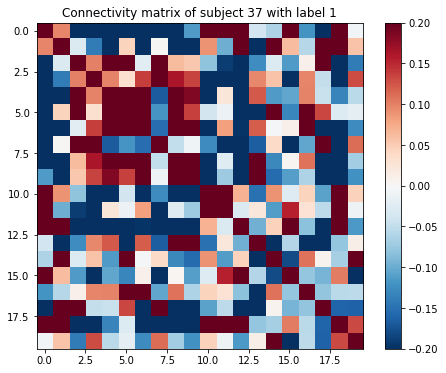

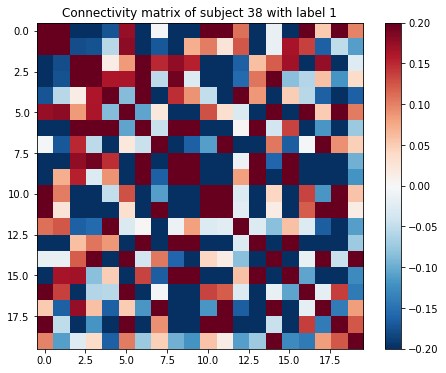

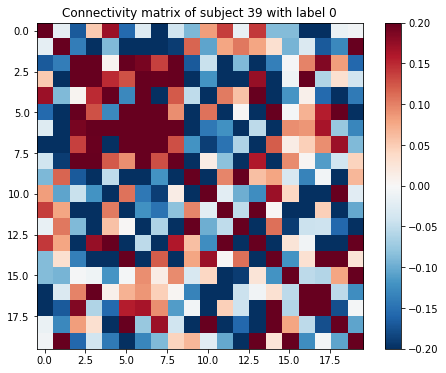

In [ ]:
#Displaying the connectomes for the most accurate kind of functional connectivity
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrices = correlation_measure.fit_transform(subjects)


for i in range(40):
    plt.figure(figsize=(8,6))
    plt.imshow(correlation_matrices[i], vmax=.20, vmin=-.20, cmap='RdBu_r')
    plt.colorbar()
    plt.title('Connectivity matrix of subject {} with label {}'.format(i, labels[i]))

In [ ]:
#Separating the correlation matrices between treatment and control subjects
adhd_correlations = []
control_correlations = []
for i in range(40):
    if labels[i] == 1:
        adhd_correlations.append(correlation_matrices[i])
    else:
        control_correlations.append(correlation_matrices[i])

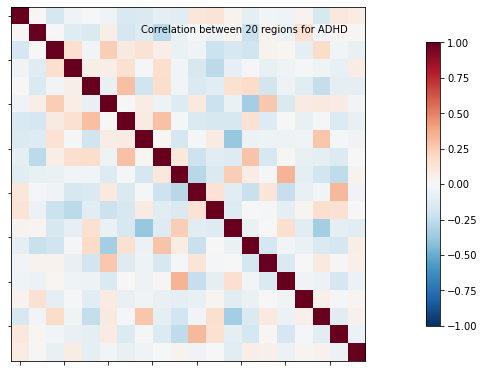

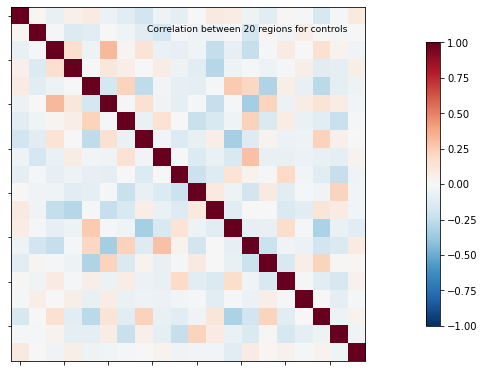

In [ ]:
#Getting the mean correlation matrix across all treatment subjects
mean_correlations_adhd = np.mean(adhd_correlations, axis=0).reshape(time_series.shape[-1],
                                                          time_series.shape[-1])

#Getting the mean correlation matrix across all control subjects
mean_correlations_control = np.mean(control_correlations, axis=0).reshape(time_series.shape[-1],
                                                          time_series.shape[-1])

#Visualizing the mean correlation
plotting.plot_matrix(mean_correlations_adhd, vmax=1, vmin=-1,
                               colorbar=True, title='Correlation between 20 regions for ADHD')

plotting.plot_matrix(mean_correlations_control, vmax=1, vmin=-1,
                               colorbar=True, title='Correlation between 20 regions for controls')

#Getting the center coordinates from the component decomposition to use as atlas labels
coords = plotting.find_probabilistic_atlas_cut_coords(components_img)

#Visualize diff [ADHD vs Controls]

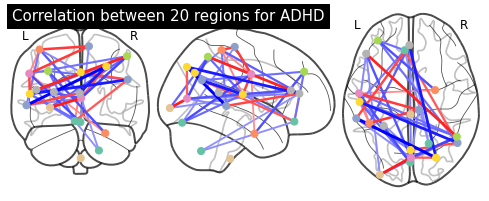

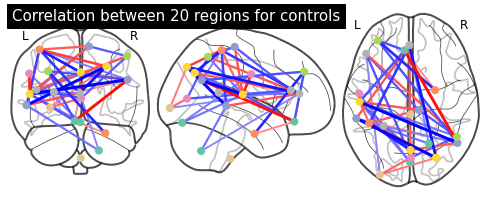

In [ ]:
#Plotting the connectome with 80% edge strength in the connectivity
plotting.plot_connectome(mean_correlations_adhd, coords,
                         edge_threshold="80%", title='Correlation between 20 regions for ADHD')

plotting.plot_connectome(mean_correlations_control, coords,
                         edge_threshold="80%", title='Correlation between 20 regions for controls')
plotting.show()

In [ ]:
#Creating the equivalent interactive visualization
view = plotting.view_connectome(mean_correlations_adhd, coords, edge_threshold='80%')
view

#Classifying NN model

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(correlation_matrices, labels, test_size=0.3)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train)
print(y_test)

(28, 20, 20)
(12, 20, 20)
[1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0]
[0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1]


In [ ]:
# connectivity_biomarkers['correlation'].shape[:] ##(40,210)
# X_train.shape ##(28,20,20) 
# y_train2 = np.asarray(y_train) 
# np.asarray(labels).shape (40,)
# correlation_matrices.shape ##(40,20,20)

(40,)

In [ ]:
#Creating the classification model
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

classifier = Sequential()
#First Hidden Layer
classifier.add(Dense(32, activation='tanh', kernel_initializer='random_normal', input_shape=connectivity_biomarkers['correlation'].shape[1:]))
#Second  Hidden Layer
classifier.add(Dense(16, activation='relu', kernel_initializer='random_normal'))
#Third  Hidden Layer
classifier.add(Dense(16, activation='relu', kernel_initializer='random_normal'))
#Output Layer
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

In [ ]:
#Compiling the model
classifier.compile(optimizer = Adam(lr =.0001),loss='binary_crossentropy', metrics =['accuracy'])

In [ ]:
#Fitting the model
classifier.fit(np.array(X_train),np.array(y_train), batch_size=32, epochs=100)

Epoch 1/100


ValueError: ignored

In [ ]:
y_pred=classifier.predict(X_test,batch_size=32)
y_pred =(y_pred>0.5)
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred)
print(cm)
cr = classification_report(y_test, y_pred)
print(cr)